# Sentiment analysis

## Introduction
In this tutorial you will be learning sentiment analysis. Sentiment analysis is extracting sentiments (i.e. positive, negative, neurtral) from movie reviews, product reviews, social media posts, etc. Often, as these entities are phrases or few sentences we can leverage lstms to learn sentiments from them with the help of a labelled dataset. First we will download and have a look at the data we will be using. We then use a `keras.preprocessing.text.Tokenizer` to preprocess the text. Afterwards we will define a model in Keras that can be used to learn sentiments. Finally we will evaluate the performance of the LSTM model and compared it to the results of a RNN.

## Why sentiment analysis
Sentiment analysis broadly can be described as follows.

> Given a phrase/sentence/short paragraph extracting whether the corpus carry a positive/negative/neutral sentiment

From the lense of a model, it might look like below.

![Sentiment overview](../images/sentiment_overview.png)

### Applications
Let's now understand why we need sentiment analysis. Humans are emotional beings. Therefore understanding emotions/sentiments of people is important for delivering good products and services, ensuring their well-being. 

* Sentiment analysis can be used to extract the negative feedback and group them by the products services. 
* Sentiment analysis can be used to analyse social media posts and detect if someone is having suicidal thoughts/depression.
* Sentiment analysis can be used to compute movie ratings automatically

### Challenges
* Double negation: `I do not dislike that movie`
* Difference in word ordering: `That movie was great, not`
* Sarcasm: `I enjoyed the late delivery of it so much!`

## Overview of deep sequential models

Sentiment analysis can be naturally formulated as a sequential task. Therefore to solve this task sequential models can be used. Sequential models contain a special memory state which allows them to look at sequence of data, while remembering past data. Long Short-Term Memory (LSTM) cell is one of the most-renowned sequental model. Here we will look at LSTM in more detail.

### High-level overview of an LSTM cell

On high-level an LSTM cell will look like below. First, LSTM cell has following components:
* Input: an input coming into the cell (e.g. a word vector)
* Cell state: the interenal cell state (i.e. memory)
* Output/Hidden state: a hidden state used to compute the final prediction
* Input gate: Determines how much of current input read into the cell state
* Forget gate: Determines how much of previous cell state (t-1) is read into the current cell state (t)
* Output gate: How much of the cell state filters through as the output

![LSTM high-level](../images/abstract_lstm.png)

### Diving deep into an LSTM cell

Below we show the full computations for a LSTM cell.

![LSTM complete](../images/lstm_architecture_complete.png)

## Implementing an LSTM based sentiment analyser


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import requests 
import tarfile
from io import StringIO
import os
import re

import pickle
import tarfile
import random
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, SimpleRNN, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
%matplotlib inline

## Downloading and loading data

In [2]:
dataset_url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

def download_movie_reviews(url):
    """ Downloading and loading the data """
    
    def read_tar(file):
        """ Try loading the data if it is already downloaded """
        text_data, labels = [],[]
        tar = tarfile.open(file, "r:gz")
        for member in tar.getmembers():
                
            if re.match(r"aclImdb\/train\/(?:pos|neg)\/\w+.txt",member.name):
                text = tar.extractfile(member).read().decode('utf-8')
                if member.name.startswith('aclImdb/train/pos'):
                    labels.append(1)
                    text_data.append(text)
                elif member.name.startswith('aclImdb/train/neg'):
                    labels.append(0)
                    text_data.append(text)
                else:
                    continue
                    
        return text_data, labels
    
    file = os.path.join('movie-review-data', "aclImdb_v1.tar.gz")
    
    try:
        """ Try loading the data if it is already downloaded """
        return read_tar(file)

    except FileNotFoundError:
        """ If the file is not there, download the file """
        res = requests.get(url, stream=True)
        print('Making a directory movie-review-data to store data')
        if not os.path.exists('movie-review-data'):
            os.mkdir('movie-review-data')
        with open(file, 'wb') as f:
            print('Downloading data')
            f.write(res.content)
            print('Download finished.')
        
        return read_tar(file)
        
    except Exception as ex:
        raise ex
        
orig_text_data, orig_labels = download_movie_reviews(dataset_url)
print('Found {} reviews'.format(len(orig_text_data)))
print('Found {} positive reviews and {} negative reviews'.format(
    sum(orig_labels), len(orig_labels)-sum(orig_labels))
     )

Making a directory movie-review-data to store data
Download finished.
Found 25000 reviews
Found 12500 positive reviews and 12500 negative reviews


## Subsample and shuffle data

Here we will shuffle our dataset and extract only `10000` reviews.

In [3]:
text_data, labels = list(orig_text_data), list(orig_labels)
data_size =10000

# Shuffling data
random.Random(100).shuffle(text_data)
random.Random(100).shuffle(labels)

# Removing newline characters with 
text_data = [t.replace('\n','') for t in text_data[:data_size]]
labels = labels[:data_size]

# Printing some stats
print('Found {} reviews'.format(len(text_data)))
print('\nFound {} positive reviews and {} negative reviews'.format(
    sum(labels), len(labels)-sum(labels))
     )

print('\nSample data ')
print('\t', text_data[0][:100])
print('\t', text_data[1][:100])
print('\t', text_data[5000][:100])
print('\t', text_data[5001][:100])

# Printing some reviews (positive)
print('\nSome positive reviews')
i = 0
for rev, lbl in zip(text_data, labels):
    if i==3:
        break
    if lbl==1:
        print(rev[:100])
        i+=1

# Printing some reviews (negative)
print('\nSome negative reviews')
i = 0
for rev, lbl in zip(text_data, labels):
    if i==3:
        break
    if lbl==0:
        print(rev[:100])
        i+=1
        

Found 10000 reviews

Found 4994 positive reviews and 5006 negative reviews

Sample data 
	 Even for the cocaine laced 1980's this is a pathetic. I don't understand why someone would want to w
	 Sometimes it takes a film-making master like Kubrick to bring that extra little something, that uniq
	 It's so sad that Romanian audiences are still populated with vulgar and uneducated individuals who r
	 Several young Iranian women dress as boys and try to get into a World Cup qualifying match between I

Some positive reviews
Sometimes it takes a film-making master like Kubrick to bring that extra little something, that uniq
A classy film pulled in 2 directions. To its advantage it is directed by Wes Craven. On the downside
I find this movie very enjoyable. The plot is simple and easily digestible, the humour is light and 

Some negative reviews
Even for the cocaine laced 1980's this is a pathetic. I don't understand why someone would want to w
I watched this hoping to find out something I did

## Fitting a Tokenizer

Here we define several hyperparameters and  we fit a tokenizer with the training data. This tokenizer will be used to tokenize test data.

In [4]:
vocab_size = 2500 # Vocabulary size
timesteps = 100 # Number of timesteps
train_size = 8000 # Train data size

""" Defining and fitting a tokenizer """
tokenizer = Tokenizer(num_words=vocab_size, oov_token='UNK')

tokenizer.fit_on_texts(text_data[:train_size])

## Padding and encoding text

In [6]:
# Convert all texts to sequences
review_sequences = tokenizer.texts_to_sequences(text_data)

# Pad sequences to a specific length
pad_reviews = pad_sequences(review_sequences, padding='pre', maxlen=timesteps)
labels = np.array(labels)

# Let's print some data
print('\nWe have {} reviews.'.format(len(text_data)))

print('\nPrinting some reviews...')
print(text_data[0][:100])
print(text_data[1][:100])

print('\nPrinting some sequences')
print(pad_reviews[1][:10])
print(pad_reviews[5][:10])

print("\nFound {} positve and {} negative labels".format(np.sum(labels==1.0), np.sum(labels==0.0)))


We have 10000 reviews.

Printing some reviews...
Even for the cocaine laced 1980's this is a pathetic. I don't understand why someone would want to w
Sometimes it takes a film-making master like Kubrick to bring that extra little something, that uniq

Printing some sequences
[  1   3   5 259   2   1 131   8   8  73]
[  99    1    5 1609   34  857   17   52  112    1]

Found 4994 positve and 5006 negative labels


## Defining a Keras Model

In [7]:
""" Clearing and resetting the session """
K.clear_session()
tf.reset_default_graph()

hidden_size = 128

""" Defining model layers """
# Defining input layer
inputs = Input(shape=(timesteps,),name='w_i')

# Defining the embedding layer
embeds = Embedding(vocab_size, 128, input_length=timesteps, name='embeddings_i')(inputs)

# Defining the LSTM layer
lstm_out = LSTM(hidden_size, return_sequences=False, return_state=False, dropout=0.5)(embeds)

# Defining the dense layer
preds = Dense(2, activation='softmax')(lstm_out)

""" Defining and compiling the model """
model = Model(inputs=inputs, outputs=preds)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
w_i (InputLayer)             (None, 100)               0         
_________________________________________________________________
embeddings_i (Embedding)     (None, 100, 128)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 451,842
Trainable params: 451,842
Non-trainable params: 0
_________________________________________________________________


## Training the Sentiment Analyzer

In [17]:
batch_size=100
for ep in range(5):
    
    accuracy = []
    train_losses = []
    """ Training phase """
    for bi in range(0, train_size, batch_size):
        # Getting one batch of inputs and outputs
        inp, out = pad_reviews[bi:bi+batch_size,:], to_categorical(labels[bi:bi+batch_size], num_classes=2)
        
        # Training the model
        model.train_on_batch(inp, out)
        
        # Evaluate the model
        l, acc= model.evaluate(inp, out, verbose=0)
        
        train_losses.append(l)
    
    """ Test phase """
    for bi in range(train_size, data_size, batch_size):
        # Getting one batch of inputs and outputs
        inp, out = pad_reviews[bi:bi+batch_size,:], to_categorical(labels[bi:bi+batch_size], num_classes=2)
        
        # Evaluate the model
        l, acc= model.evaluate(inp, out, verbose=0)
        accuracy.append(acc)
    
    # Printing epoch statistics
    print('Test accuracy for epoch {}: {}'.format(ep+1, np.mean(accuracy)*100.0))
    print('Train loss for epoch {}: {}'.format(ep+1, np.mean(train_losses)))

Test accuracy for epoch 1: 0.768
Train loss for epoch 1: 0.6225224769487976
Test accuracy for epoch 2: 0.8230000000000001
Train loss for epoch 2: 0.3797170697115361
Test accuracy for epoch 3: 0.7905
Train loss for epoch 3: 0.2980907634478062
Test accuracy for epoch 4: 0.8049999999999999
Train loss for epoch 4: 0.263183373849839
Test accuracy for epoch 5: 0.8009999999999999
Train loss for epoch 5: 0.24179773901123552


## Defining RNN-based Model

In [18]:
K.clear_session()
tf.reset_default_graph()

hidden_size = 128

""" Defining model layers """
# Defining input layer
inputs = Input(shape=(timesteps,),name='w_i')

# Defining the embedding layer
embeds = Embedding(vocab_size, 128, input_length=timesteps, name='embeddings_i')(inputs)

# Defining the LSTM layer
lstm_out = SimpleRNN(hidden_size, return_sequences=False, return_state=False)(embeds)

# Defining the dense layer
preds = Dense(2, activation='softmax')(lstm_out)

""" Defining and compiling the model """
model = Model(inputs=inputs, outputs=preds)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
w_i (InputLayer)             (None, 100)               0         
_________________________________________________________________
embeddings_i (Embedding)     (None, 100, 128)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               32896     
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 353,154
Trainable params: 353,154
Non-trainable params: 0
_________________________________________________________________


## Training the RNN based Sentiment Analyzer

In [19]:
batch_size=100
for ep in range(5):
    
    rnn_accuracy = []
    rnn_train_losses = []
    
    """ Training phase """
    for bi in range(0, train_size, batch_size):
        inp, out = pad_reviews[bi:bi+batch_size,:], to_categorical(labels[bi:bi+batch_size], num_classes=2)
        model.train_on_batch(inp, out)
        l, acc= model.evaluate(inp, out, verbose=0)
        rnn_train_losses.append(l)
        
    """ Testing phase """
    for bi in range(train_size, data_size, batch_size):
        inp, out = pad_reviews[bi:bi+batch_size,:], to_categorical(labels[bi:bi+batch_size], num_classes=2)
        l, acc= model.evaluate(inp, out, verbose=0)
        rnn_accuracy.append(acc)
    
    # Printing epoch statistics
    print('Test accuracy for epoch {}: {}'.format(ep+1, np.mean(rnn_accuracy)*100.0))
    print('Train loss for epoch {}: {}'.format(ep+1, np.mean(rnn_train_losses)))

Test accuracy for epoch 1: 0.555
Train loss for epoch 1: 0.6709802968502044
Test accuracy for epoch 2: 0.6665
Train loss for epoch 2: 0.525450867794454
Test accuracy for epoch 3: 0.7655
Train loss for epoch 3: 0.3171661130739376
Test accuracy for epoch 4: 0.772
Train loss for epoch 4: 0.2082878090525046
Test accuracy for epoch 5: 0.7414999999999999
Train loss for epoch 5: 0.12143262963916639


## Plotting LSTM vs RNN accuracies 

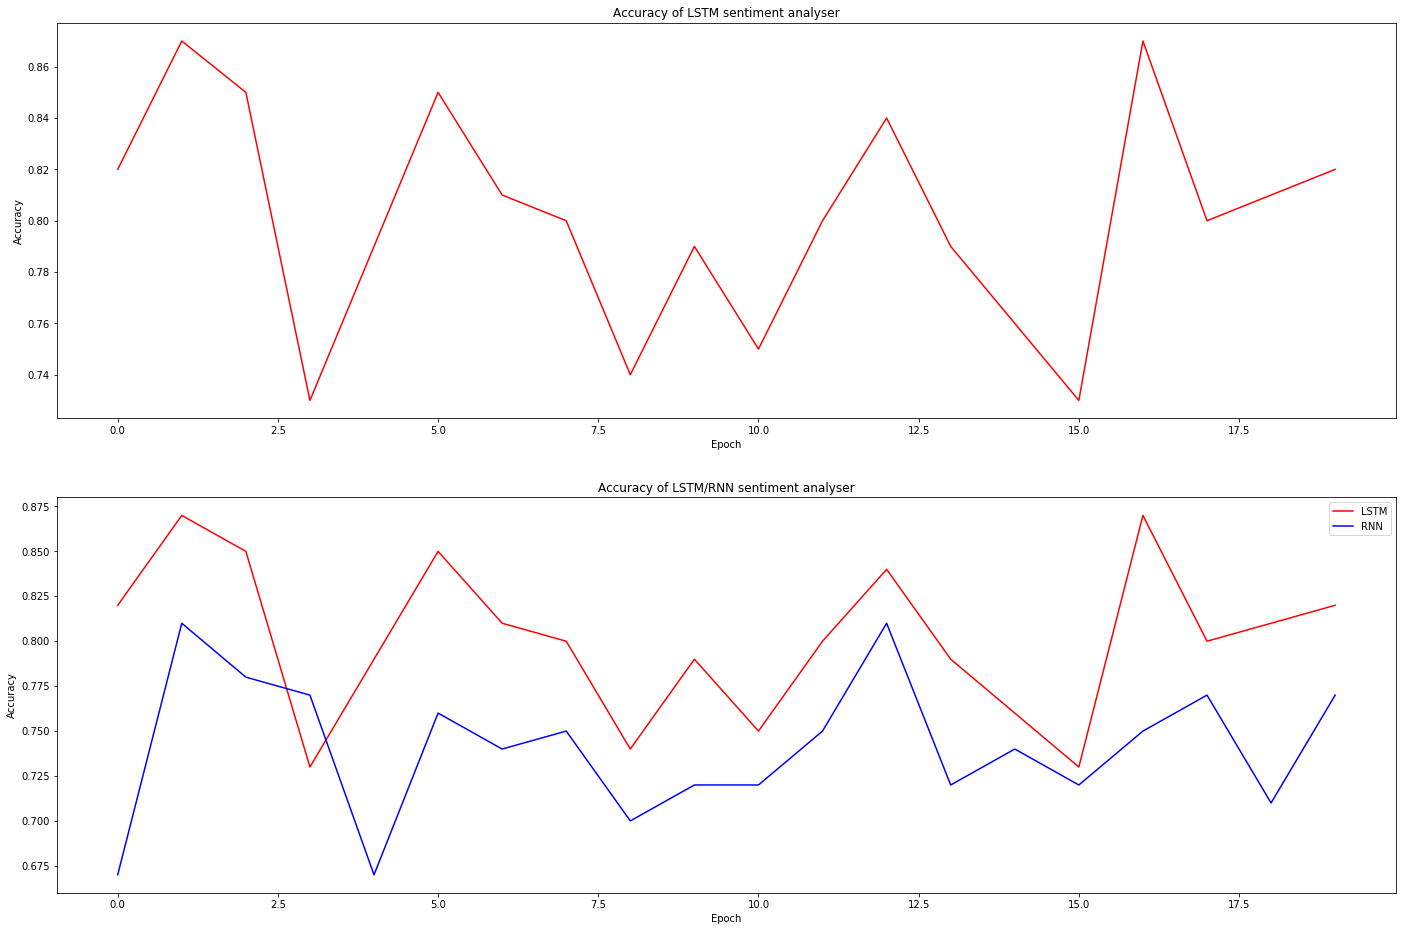

In [22]:
# Plotting LSTM accuracy
plt.subplots(2,1, figsize=(24,16))
plt.subplot(211)
plt.plot(np.arange(len(accuracy)), accuracy, color='r', label='LSTM')
plt.title('Accuracy of LSTM sentiment analyser')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plotting RNN vs LSTM accuracy
plt.subplot(212)
plt.plot(np.arange(len(accuracy)), accuracy, color='r', label='LSTM')
plt.plot(np.arange(len(rnn_accuracy)), rnn_accuracy , color='b', label='RNN')
plt.title('Accuracy of LSTM/RNN sentiment analyser')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()